# Testing degradation on ABC vs true distribution

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

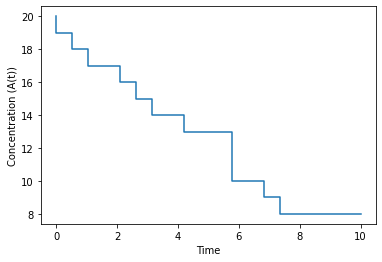

In [3]:
np.random.seed(2)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 20)

values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0], [0.3])

# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('Time')
plt.ylabel('Concentration (A(t))')

import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

my_path = os.path.abspath(__file)


plt.savefig(my_path + '/degradation_model.pdf')

# res_kl_adaptive_pmc = resulting_kl

# plt.show()

In [4]:
np.random.seed(2)

from math import comb

n_0 = 20

# Probability for one data point
def compute_prob(n, t, k):
    exp_term = np.exp(-k * n * t)
    comb_term = comb(n_0, int(n)) 
    t_term = (1 - np.exp(-k * t)) 
    return exp_term * comb_term * (t_term ** (n_0 - n))

# Probability for multiple data points
def prob_gen(data, times, k):
    all_prob = 1.0
    for i in range(len(data)):
        computed_prob = compute_prob(data[i][0], times[i], k)
        all_prob *= computed_prob
    return all_prob


# Compute integral
from scipy import integrate

func = lambda x : prob_gen(values, times, x)
int_val = integrate.quad(func, 0.01, 0.3)
print("likelihood integrate value="+str(int_val[0]))

# True posterior
def posterior(data, times, k):
    return prob_gen(data, times, k) / int_val[0]

thetas = np.linspace(0.01, 0.3, 200)
true_prob = []
for i in range(len(thetas)):
    true_prob.append(posterior(values, times, thetas[i]))

v_func = lambda x : posterior(values, times, x)
i_val = integrate.quad(v_func, 0.01, 0.3)

print("posterior integrate value="+str(i_val[0]))

likelihood integrate value=5.086995413811021e-16
posterior integrate value=0.9999392938746746


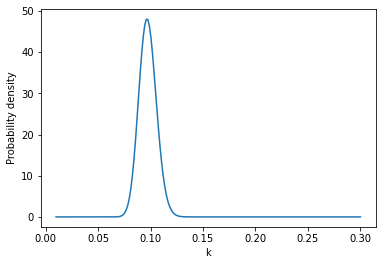

In [5]:
plt.plot(thetas, true_prob)

import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

my_path = os.path.abspath(__file)

plt.ylabel("Probability density")
plt.xlabel("k")
plt.savefig(my_path + '/degradation_posterior.pdf')
# plt.show()

# Rejection ABC

In [21]:
error_thresholds = [7, 5, 3, 2, 1]
resulting_kl = []

np.random.seed(1)
for error in error_thresholds:
    print("Starting error " + str(error))
    inter_kl = []
    # Perform 5 runs
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior)

        # set threshold
        abc.sampler().set_threshold(error)

        # set target number of samples
        abc.set_n_samples(500)

        # log to screen
        abc.set_log_to_screen(True)

        print('Running...')
        samples  = abc.run()
        print('Done')

        # computing the KDE and KL functions
        def kl_func(y, post, kde_skl):
            part = posterior(values, times, y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                return np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div(x, bandwidth, posterior, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func(y, posterior, kde_skl)
            return integrate.quad(fun, 0.01, 0.3)

        def s_posterior(theta):
            return posterior(values, times, theta)

        t_samples = np.array(samples[:, 0])

        inter_kl.append(kl_div(t_samples, error * 0.005, s_posterior)[0])
    resulting_kl.append(inter_kl)
    print("finished computing kde + "+str(resulting_kl[-1]))

Starting error 7
Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     1      1                0:00.0
2     2      1                0:00.0
3     3      1                0:00.0
20    21     0.952380952381   0:00.0
40    45     0.888888889      0:00.0
60    69     0.869565217      0:00.0
80    91     0.879120879      0:00.1
100   114    0.877192982      0:00.1
120   137    0.875912409      0:00.1
140   157    0.891719745      0:00.1
160   182    0.879120879      0:00.1
180   207    0.869565217      0:00.1
200   228    0.877192982      0:00.1
220   251    0.876494024      0:00.1
240   272    0.882352941      0:00.1
260   292    0.890410959      0:00.1
280   313    0.89456869       0:00.2
300   335    0.895522388      0:00.2
320   359    0.891364902507   0:00.2
340   388    0.87628866       0:00.2
360   411    0.875912409      0:00.2
380   432    0.87962963       0:00.2
400   456    0.877192982      0:00.2
420   479    0.876826722      0:00.2

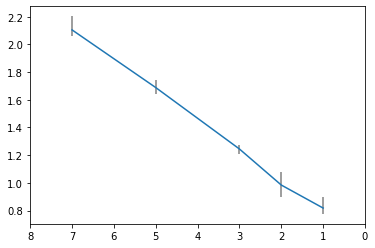

In [22]:
resulting_kl = np.array(resulting_kl)
mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


fig, ax = plt.subplots()


# create stacked errorbars:
plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='gray')
plt.xlim(8, 0)

res_kl_abc_rej = resulting_kl

# PMC Degradation (with smc)

In [18]:
error_thresholds = [7, 5, 3, 2, 1]
resulting_kl = []

np.random.seed(0)
for error in error_thresholds:
    print("Starting error " + str(error))
    inter_kl = []
    # Perform 5 runs
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
        # set initial threshold
        abc.sampler().set_threshold_schedule(np.array([error * 1.5, error * 1.3, error]))

        # produce intermediate distributions of size 1000
        abc.sampler().set_intermediate_size(500)

        # set target number of samples
        abc.set_n_samples(1500)

        # log to screen
        abc.set_log_to_screen(True)

        samples = abc.run()
        print("Done")

        # computing the KDE and KL functions
        def kl_func(y, post, kde_skl):
            part = posterior(values, times, y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                return np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div(x, bandwidth, posterior, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func(y, posterior, kde_skl)
            return integrate.quad(fun, 0.01, 0.3)

        def s_posterior(theta):
            return posterior(values, times, theta)

        t_samples = np.array(samples[1000:, 0])

        inter_kl.append(kl_div(t_samples, error * 0.005, s_posterior)[0])
    resulting_kl.append(inter_kl)
    print("finished computing kde + "+str(resulting_kl[-1]))

Starting error 7
Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=10.5
Iter. Eval. Acceptance rate Time m:s
1     1      1                0:00.0
2     2      1                0:00.0
3     3      1                0:00.0
20    20     1                0:00.0
40    40     1                0:00.0
60    60     1                0:00.0
80    80     1                0:00.0
100   100    1                0:00.1
120   120    1                0:00.1
140   140    1                0:00.1
160   160    1                0:00.1
180   180    1                0:00.1
200   200    1                0:00.1
220   220    1                0:00.1
240   240    1                0:00.1
260   260    1                0:00.1
280   280    1                0:00.1
300   300    1                0:00.2
320   320    1                0:00.2
340   340    1                0:00.2
360   360    1                0:00.2
380   380    1                0:00.2
400   400    1                0:00.2
420   420    1     

[[1.96115676 1.96654996 2.04625638 2.03307328 2.07135396]
 [1.63850414 1.54300159 1.68752005 1.65371986 1.61144565]
 [1.08659834 1.10223574 1.08685313 1.06985791 1.04458235]
 [0.7717194  0.87125276 0.84310649 0.81969206 0.90477761]
 [0.60537866 0.59848475 0.62977473 0.64478052 0.6774634 ]]
[7, 5, 3, 2, 1]


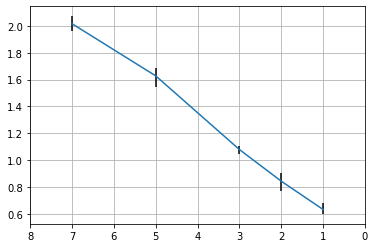

In [20]:
print(resulting_kl)
print(error_thresholds)


resulting_kl = np.array(resulting_kl)
mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


fig, ax = plt.subplots()


# create stacked errorbars:
plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='black')
plt.xlim(8, 0)
plt.grid(True)

plt.show()
res_kl_true_pmc_rej = resulting_kl

# ABC SMC

In [24]:
error_thresholds = [7, 5, 3, 2, 1]
resulting_kl = []

np.random.seed(0)
for error in error_thresholds:
    print("Starting error " + str(error))
    inter_kl = []
    # Perform 5 runs
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
        # set initial threshold
        abc.sampler().set_threshold_schedule(np.array([error * 1.5, error * 1.3, error]))

        # produce intermediate distributions of size 1000
        abc.sampler().set_intermediate_size(100)

        # set target number of samples
        abc.set_n_samples(700)

        # log to screen
        abc.set_log_to_screen(True)

        samples = abc.run()
        print("Done")

        # computing the KDE and KL functions
        def kl_func(y, post, kde_skl):
            part = posterior(values, times, y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                return np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div(x, bandwidth, posterior, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func(y, posterior, kde_skl)
            return integrate.quad(fun, 0.01, 0.3)

        def s_posterior(theta):
            return posterior(values, times, theta)

        t_samples = np.array(samples[200:, 0])

        inter_kl.append(kl_div(t_samples, error * 0.005, s_posterior)[0])
    resulting_kl.append(inter_kl)
    print("finished computing kde + "+str(resulting_kl[-1]))

Starting error 7
Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=10.5
Iter. Eval. Acceptance rate Time m:s
1     1      1                0:00.0
2     2      1                0:00.0
3     3      1                0:00.0
20    20     1                0:00.0
40    40     1                0:00.0
60    60     1                0:00.0
80    80     1                0:00.1
Starting t=1, with threshold=9.1
100   100    1                0:00.1
120   120    1                0:00.1
140   140    1                0:00.1
160   160    1                0:00.1
180   180    1                0:00.1
Starting t=2, with threshold=7.0
200   200    1                0:00.4
220   224    0.982142857      0:00.4
240   246    0.975609756      0:00.5
260   267    0.973782772      0:00.5
280   290    0.965517241      0:00.5
300   310    0.967741935      0:00.5
320   330    0.969696969697   0:00.5
340   350    0.971428571      0:00.5
360   371    0.970350404      0:00.5
380   392    0.969387755102

[[2.1102341006910335, 1.9441584222005979, 2.2028916672455283, 1.926660125936304, 2.034623535566795], [1.618268935410963, 1.7935946206875029, 1.687419734778919, 1.6474609113790681, 1.5572028540830465], [1.1144844556340712, 1.1375896476260021, 1.0828102260586796, 1.0136603324487277, 1.153003348940301], [0.7352383872302204, 0.8064896458048239, 0.8100690782990518, 0.8193148298844046, 0.9129467913567996], [0.5940430315406962, 0.6324931891499037, 0.6150195211161793, 0.6173443234136167, 0.7378450728807578]]
[7, 5, 3, 2, 1]


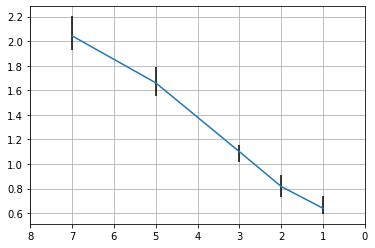

In [25]:
print(resulting_kl)
print(error_thresholds)

resulting_kl = np.array(resulting_kl)
mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


# create stacked errorbars:
plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='black')
plt.xlim(8, 0)
plt.grid(True)

plt.show()
res_kl_fake_pmc_rej = resulting_kl

# Compare all algorithms errors

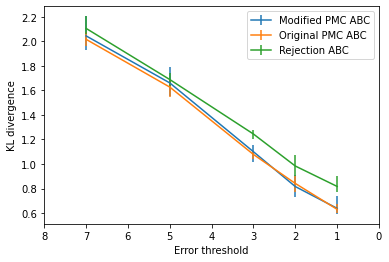

In [26]:

mins_fake_pmc_kl = res_kl_fake_pmc_rej.min(1)
maxes_fake_pmc_kl = res_kl_fake_pmc_rej.max(1)
means_fake_pmc_kl = res_kl_fake_pmc_rej.mean(1)

mins_true_pmc_kl = res_kl_true_pmc_rej.min(1)
maxes_true_pmc_kl = res_kl_true_pmc_rej.max(1)
means_true_pmc_kl = res_kl_true_pmc_rej.mean(1)

mins_abc_rej_kl = res_kl_abc_rej.min(1)
maxes_abc_rej_kl = res_kl_abc_rej.max(1)
means_abc_rej_kl = res_kl_abc_rej.mean(1)

plt.errorbar(error_thresholds, means_fake_pmc_kl, [means_fake_pmc_kl - mins_fake_pmc_kl, maxes_fake_pmc_kl - means_fake_pmc_kl], label='Modified PMC ABC')
plt.errorbar(error_thresholds, means_true_pmc_kl, [means_true_pmc_kl - mins_true_pmc_kl, maxes_true_pmc_kl - means_true_pmc_kl], label='Original PMC ABC')
plt.errorbar(error_thresholds, means_abc_rej_kl, [means_abc_rej_kl - mins_abc_rej_kl, maxes_abc_rej_kl - means_abc_rej_kl], label='Rejection ABC')

plt.xlim(8, 0)
plt.legend()

ax.plot(error_thresholds, res_kl_abc_rej, label='Rejection ABC')
ax.grid(True)
ax.legend()

import os
__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"
my_path = os.path.abspath(__file)

plt.ylabel("KL divergence")
plt.xlabel("Error threshold")
plt.savefig(my_path + '/degradation_errors_all.pdf')

# Adaptive PMC ABC

In [118]:
error_thresholds = [0.5, 0.4, 0.3, 0.2]
resulting_kl = []

for error in error_thresholds:
    print("Starting error " + str(error))
    inter_kl = []
    # Perform 5 runs
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

        # set threshold
        abc.sampler().set_N_l(300)

        # set p_acc_min
        abc.sampler().set_p_acc_min(error)

        # set target number of samples
        abc.set_n_samples(500)

        # log to screen
        abc.set_log_to_screen(True)

        print('Running...')
        samples  = abc.run()
        print('Done')

        # computing the KDE and KL functions
        def kl_func(y, post, kde_skl):
            part = posterior(values, times, y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                return np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div(x, bandwidth, posterior, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func(y, posterior, kde_skl)
            return integrate.quad(fun, 0.01, 0.3)

        def s_posterior(theta):
            return posterior(values, times, theta)

        t_samples = np.array(samples[:, 0])

        inter_kl.append(kl_div(t_samples, 0.1 * error, s_posterior)[0])
    resulting_kl.append(inter_kl)
    print("finished computing kde + "+str(resulting_kl[-1]))

Starting error 0.5
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.13161507]
resulting var=[[0.00825589]]
epsilon=3.5846896657869842
w_mean=[0.11940776]
resulting var=[[0.00481064]]
epsilon=2.8017851452243803
w_mean=[0.11602766]
resulting var=[[0.00443712]]
Iter. Eval. Acceptance rate Time m:s
1     4      125              0:34.0
cnt_sampled=1100
Halting: target number of samples (500) reached.
Done
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.12522337]
resulting var=[[0.00799293]]
epsilon=3.383784863137726
w_mean=[0.11159254]
resulting var=[[0.00357915]]
epsilon=2.7202941017470885
w_mean=[0.11072199]
resulting var=[[0.00259775]]
Iter. Eval. Acceptance rate Time m:s
1     4      125              0:33.9
cnt_sampled=1100
Halting: target number of samples (500) reached.
Done
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.13303714]
resulting var=[[0.00754351]]
epsilon=3.4713109915419564
w_mean=[0.11153766]
resultin

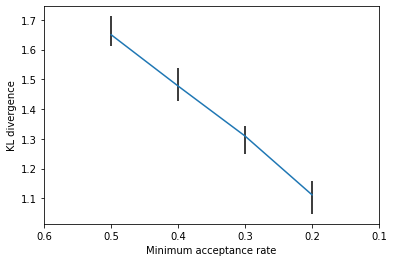

In [121]:
resulting_kl = np.array(resulting_kl)
mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


# create stacked errorbars:
plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='black')
plt.xlim(0.6, 0.1)
# plt.grid(True)

# plt.show()


import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

my_path = os.path.abspath(__file)

plt.ylabel("KL divergence")
plt.xlabel("Minimum acceptance rate")
plt.savefig(my_path + '/degradation_errors_adaptive.pdf')

res_kl_adaptive_pmc = resulting_kl